In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!mkdir -p ~/.kaggle
!cp drive/MyDrive/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download --unzip -d masoudnickparvar/brain-tumor-mri-dataset

 99% 147M/149M [00:00<00:00, 150MB/s]
100% 149M/149M [00:01<00:00, 156MB/s]


In [3]:
# PyTorch
import torch
from torch import nn
from torch import optim
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
# I want to be able to replicate the results, therefore
# I use a hard coded seed
torch.manual_seed(69)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import copy

In [4]:
 transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [5]:
train_data = ImageFolder('Training', transform = transformations)
test_data = ImageFolder('Testing', transform = transformations)

In [6]:
# Checking if there is a cuda compatible gpu available
cuda_available = torch.cuda.is_available()

# If cuda is available we are going to use it
# otherwise we are going to train the model on the cpu
device = (
    torch.device('cuda')
    if cuda_available
    else torch.device('cpu')
)

print(f'We are going to train the model using {device}.')

We are going to train the model using cuda


In [7]:
from collections import OrderedDict

model = models.resnet50(pretrained = True)

for param in model.parameters():
    param.required_grad = False
    
num_ftrs = model.fc.in_features

#The better one 
model.fc = nn.Sequential(
    nn.BatchNorm1d(num_ftrs),
    nn.Linear(num_ftrs, 16),
    nn.ReLU(),
    nn.BatchNorm1d(16),
    nn.Linear(16, 4)
)

#model.fc = nn.Linear(nr_feat, 4)
#model.fc = nn.Sequential(OrderedDict([('fc',nn.Linear(nr_feat,4)),('sigmoid',nn.Sigmoid())]))

#learning_rate = 1e-3. - it's not necessary
model = model.to(device)
optimizer = optim.Adam(model.parameters()) #lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()

#loss_fn = nn.BCEWithLogitsLoss()

In [8]:
# Defining the function that contains the training loop
def training_loop(
    n_epochs, optimizer, model, loss_fn,
    train_loader, test_loader, device
):
    # The following torch tensor will hold information about
    # the accuracy results after every epoch
    train_accuracy = torch.zeros(n_epochs)
    test_accuracy = torch.zeros(n_epochs)

    # The actual training_loop
    for epoch in range(n_epochs):
        model.train()
        for examples, labels in train_loader:
            # Copying these tensors to the gpu ram
            # if needed
            # If a cuda compatible gpu is not available
            # the data remains on the cpu ram 
            examples = examples.to(device=device)
            labels = labels.to(device=device)

            outputs = model(examples)
            loss = loss_fn(outputs, labels)

            # Sets the gradients of all optimized torch.Tensor to zero
            optimizer.zero_grad()
            # Back Propagation
            loss.backward()
            # the optimizer updates the parameters
            optimizer.step()

        # This loop computes the accuracy for test and train data
        # after every epoch
        model.eval()
        for name, loader, accuracy in [
            ('train', train_loader, train_accuracy),
            ('test', test_loader, test_accuracy)
        ]:
            correct = 0
            total = 0

            # This with statement turns off auto grad
            with torch.no_grad():
                for examples, labels in loader:
                    examples = examples.to(device=device)
                    labels = labels.to(device=device)

                    outputs = model(examples)
                    _, predicted = torch.max(outputs, dim=1)
                    
                    total += labels.shape[0]
                    correct += int((predicted == labels).sum())
            
            accuracy[epoch] = correct / total


        # This piece of code saves the models that has the best
        # test accuracy
        best_test_accuracy = (epoch == test_accuracy.max(dim=0)[1].item())
        if best_test_accuracy:
            best_model = copy.deepcopy(model.state_dict())

        print(
            f'Epoch {epoch + 1})', 
            f'Train Accuracy: {train_accuracy[epoch]}',
            f'Test Accuracy: {test_accuracy[epoch]}',
            f'{"Best test accuracy!" if best_test_accuracy else ""}'
        )

    # Plotting the train and test accuracy after every epoch
    plt.figure(dpi=120)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.plot(range(1, n_epochs + 1), train_accuracy)
    plt.plot(range(1, n_epochs + 1), test_accuracy)
    plt.legend(['Train Accuracy', 'Test Accuracy'])
    plt.grid()
    plt.show()

    return best_model

In [9]:
train_loader = DataLoader(train_data, batch_size = 64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size = 64, shuffle=False, num_workers=2)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1) Train Accuracy: 0.6269257664680481 Test Accuracy: 0.6193745136260986 Best test accuracy!
Epoch 2) Train Accuracy: 0.8886554837226868 Test Accuracy: 0.8726163506507874 Best test accuracy!
Epoch 3) Train Accuracy: 0.9779411554336548 Test Accuracy: 0.966437816619873 Best test accuracy!
Epoch 4) Train Accuracy: 0.8919817805290222 Test Accuracy: 0.8855835199356079 
Epoch 5) Train Accuracy: 0.8844537734985352 Test Accuracy: 0.8466818928718567 
Epoch 6) Train Accuracy: 0.9842436909675598 Test Accuracy: 0.9687261581420898 Best test accuracy!
Epoch 7) Train Accuracy: 0.9632353186607361 Test Accuracy: 0.9267734289169312 
Epoch 8) Train Accuracy: 0.9789915680885315 Test Accuracy: 0.9633867144584656 
Epoch 9) Train Accuracy: 0.6094187498092651 Test Accuracy: 0.6117467284202576 
Epoch 10) Train Accuracy: 0.9963235259056091 Test Accuracy: 0.9755911231040955 Best test accuracy!


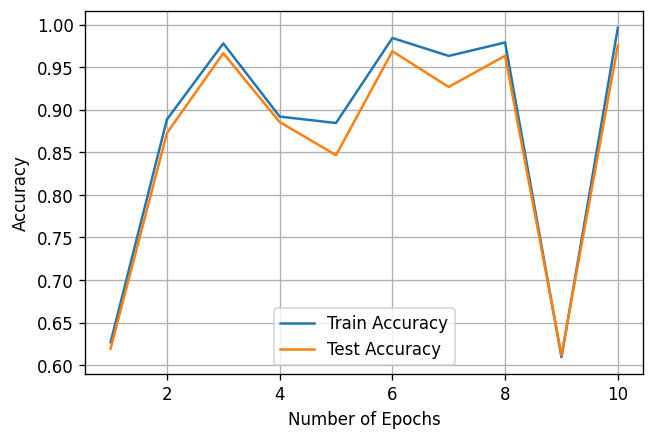

In [10]:
# Training the model
best_model = training_loop(
    n_epochs=10,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device
)

In [11]:
# Load the model that had the best test accuracy
model.load_state_dict(best_model)

<All keys matched successfully>

In [12]:
correct = 0
total = 0

y_test = torch.zeros(len(test_data))
y_pred = torch.zeros(len(test_data))
low = 0

# Make predictions on the test data
model.eval()
with torch.no_grad():
    for examples, labels in test_loader:
        examples = examples.to(device=device)
        labels = labels.to(device=device)

        outputs = model(examples)
        _, predicted = torch.max(outputs, dim=1)

        high = low + labels.shape[0]
        y_test[low : high] = labels
        y_pred[low : high] = predicted
        low = high

        total += labels.shape[0]
        correct += int((predicted == labels).sum())
            
accuracy = correct / total
accuracy

0.9755911517925248

Text(0.5, 32.08333333333333, 'Predicted Label')

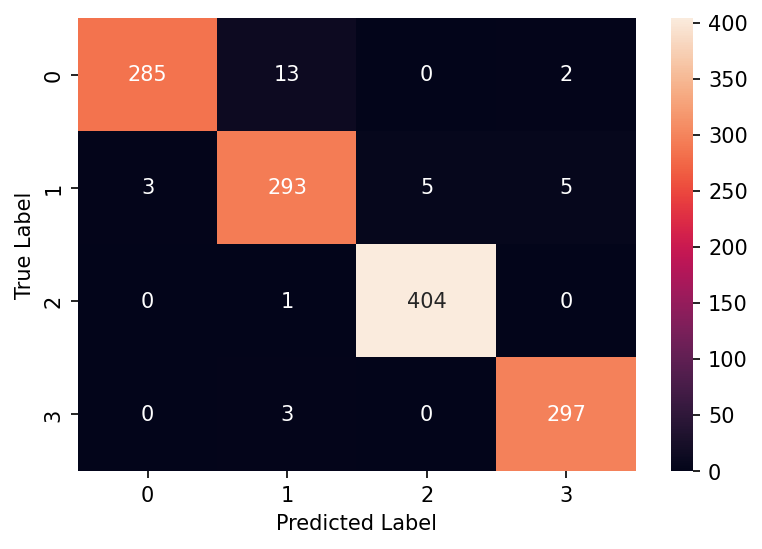

In [13]:
# Creating a Confusion Matrix plot
plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [14]:
torch.save(best_model, 'brain_tumor.pt')

In [15]:
%%shell
cp brain_tumor.pt drive/MyDrive/cvc2021